# 📝 Airbnb User Bookings Analysis

Air Bnb New User Bookings     
Predict user country destination      

필사한 커널 : [Airbnb User Bookings Analysis](https://www.kaggle.com/code/yasinnaal/airbnb-user-bookings-analysis)

In [243]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



에어비앤비의 신규 사용자는 190개국 이상의 34,000개 이상의 도시에서 머물 곳을 예약할 수 있다. 신규 사용자가 처음 여행 경험을 예약할 장소를 정확하게 예측함으로써, 에어비앤비는 커뮤니티와 더 많은 개인화된 콘텐츠를 공유하고, 첫 예약까지의 평균 시간을 줄이고, 더 나은 수요 예측을 할 수 있다.

이번 채용 경쟁에서 에어비앤비는 **신규 이용자가 어느 나라에서 첫 예약을 할지** 예측하는 데 도전한다. 답변(그리고 어떻게 그곳에 도착했는지에 대한 설명)으로 감동을 주는 카글러들은 에어비앤비에 가입할 기회를 위한 인터뷰에 고려될 것이다.

In [244]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


#add colores for plot bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']      

# Load Data

In [245]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/캐굴캐굴/6주차/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/캐굴캐굴/6주차/Dataset/sessions.csv/sessions.csv
/content/drive/MyDrive/캐굴캐굴/6주차/Dataset/sample_submission_NDF.csv/sample_submission_NDF.csv
/content/drive/MyDrive/캐굴캐굴/6주차/Dataset/age_gender_bkts.csv/age_gender_bkts.csv
/content/drive/MyDrive/캐굴캐굴/6주차/Dataset/train_users_2.csv/train_users_2.csv
/content/drive/MyDrive/캐굴캐굴/6주차/Dataset/test_users.csv/test_users.csv
/content/drive/MyDrive/캐굴캐굴/6주차/Dataset/countries.csv/countries.csv


# Combining test and train datasets

Train 데이터와 Test 데이터의 컬럼 수가 맞지 않음    

In [246]:
# convert date columns into datetime format while loading
train_path = f'/content/drive/MyDrive/캐굴캐굴/6주차/Dataset/train_users_2.csv/train_users_2.csv'
test_path = f'/content/drive/MyDrive/캐굴캐굴/6주차/Dataset/test_users.csv/test_users.csv'
booking_path = f'/content/drive/MyDrive/캐굴캐굴/6주차/Dataset/train_users_2.csv/train_users_2.csv'

In [247]:
train_df = pd.read_csv(f'{train_path}', parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
test_df= pd.read_csv(f'{test_path}',parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
bookings_data  = pd.read_csv(f'{booking_path}')

In [248]:
# Merge train and test users
users = pd.concat((train_df, test_df), axis=0, ignore_index=True)

# Remove ID's since now we are not interested in making predictions
users.drop('id',axis=1, inplace=True)

users.head()

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [249]:
set(train_df.columns.tolist()) - set(test_df.columns.tolist())

{'country_destination'}

이것이 Target값! 

In [250]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date_account_created     275547 non-null  datetime64[ns]
 1   timestamp_first_active   275547 non-null  datetime64[ns]
 2   date_first_booking       88908 non-null   datetime64[ns]
 3   gender                   275547 non-null  object        
 4   age                      158681 non-null  float64       
 5   signup_method            275547 non-null  object        
 6   signup_flow              275547 non-null  int64         
 7   language                 275547 non-null  object        
 8   affiliate_channel        275547 non-null  object        
 9   affiliate_provider       275547 non-null  object        
 10  first_affiliate_tracked  269462 non-null  object        
 11  signup_app               275547 non-null  object        
 12  first_device_typ

In [251]:
# id, label drop
# data_first_booking은 결측치가 절반 이상 -> drop
users = users.drop(['date_first_booking'], axis=1)

In [252]:
# 결측치 재조회
for i in users.columns:
    ab = users[i].isnull().sum()
    if ab != 0:
        print(i + " has {} null values.".format(ab))
        print()

age has 116866 null values.

first_affiliate_tracked has 6085 null values.

country_destination has 62096 null values.



## Missing Data 
- 성별의 경우 NaN값이 unknown인 경우도 있다. 
- 일반적으로 누락된 데이터는 NaN 방식으로 제공되지만 위에 인쇄된 데이터 프레임을 보면 성별 열에서 일부 값이 -unknown - 이므로 이 값들을 NaN으로 변환해준다, 

In [253]:
users.gender.unique()

array(['-unknown-', 'MALE', 'FEMALE', 'OTHER'], dtype=object)

- 기타는 대체 뭐임?

In [254]:
users["gender"] = users["gender"].replace('-unknown-', np.nan)

In [255]:
# NaN 비율 살펴보기 
users.gender.isnull().mean()

0.4699016864636523

In [256]:
# 전체 컬럼 missing values값 살펴보기 
users_nan = users.isnull().mean()

- 나이와 성별에 꽤 많은 NaN을 보유하고 있음
- 우리가 구축할 분류기의 성능이 저하될 수 있음
- date_first_booking같은 경우 tests users에게는 없음 , 모델링에서 제거 

In [257]:
print(int((train_df.date_first_booking.isnull().sum() / train_df.shape[0]) * 100), 
      "% 정도의 결측치가 train dataset에 포함되어있다.")

58 % 정도의 결측치가 train dataset에 포함되어있다.


## Age 


In [258]:
users.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

- max: 2014인 것을 보아 출생년도로 착각하여 답을 한게 아닐까하는 생각. 
- 그리고고 AirBnB에서 미성년자 입장 제한을 하는지..? 


<Axes: >

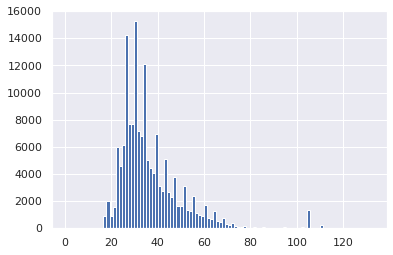

In [259]:
users[users["age"] <= 140]["age"].hist(bins=100)

In [260]:
print(sum(users.age > 122)) # 기록된 세계 최장수 인간의 나이 
print(sum(users.age < 18)) # 미성년자의 예약 제한 규정을 어긴 사람  

830
188


In [261]:
users[users.age > 122]['age'].describe()

count     830.000000
mean     2002.620482
std        94.201344
min       132.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [262]:
users[users.age > 122]['age'].unique()

array([2014., 2013., 1949., 1931., 1932., 1928., 1936., 1933., 1935.,
       1925., 1952.,  150., 1927.,  132., 1953., 1942., 1995., 2008.,
       1924., 1929., 1947., 1938., 1926., 1937., 1934., 1922., 1944.,
       1954., 1940., 1945., 2000., 2001., 1930., 1968., 1939., 1951.,
       1920., 1923., 1948., 2002., 1941.])

- 출생년도를 잘못 입력한 것으로 보임..
- 데이터 수집 날짜를 기준으로 나이를 구해도 될 것같은데 컬럼상태를 보니 쉽진 않을 듯 ... 


고로 NaN처리

In [263]:
users.loc[users.age > 95, 'age'] = np.nan
users.loc[users.age < 13, 'age'] = np.nan

In [264]:
users[users.age < 18]['age'].describe()

count    129.000000
mean      16.558140
std        0.623836
min       15.000000
25%       16.000000
50%       17.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

- 이거는 에어비앤비 측의 사용자 나이제한 여부가 있는지 잘 모르겠다 ..     
커널 주인장 왈 :     
젊은 사용자는 16세 이상 사용자의 50%가 허용 범위에 있는 것으로 보인다. 우리는 특이치를 전달해야 한다.    
제가 생각한 간단한 것은 수용 범위를 설정하고 그 안에 있는 것들을 NaN에 보낸다.

## Data Types

In [265]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date_account_created     275547 non-null  datetime64[ns]
 1   timestamp_first_active   275547 non-null  datetime64[ns]
 2   gender                   146067 non-null  object        
 3   age                      155825 non-null  float64       
 4   signup_method            275547 non-null  object        
 5   signup_flow              275547 non-null  int64         
 6   language                 275547 non-null  object        
 7   affiliate_channel        275547 non-null  object        
 8   affiliate_provider       275547 non-null  object        
 9   first_affiliate_tracked  269462 non-null  object        
 10  signup_app               275547 non-null  object        
 11  first_device_type        275547 non-null  object        
 12  first_browser   

In [266]:
# category 데이터로 변환 
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    users[categorical_feature] = users[categorical_feature].astype('category')

In [267]:
# datetime 데이터로 변환환
users['date_account_created'] = pd.to_datetime(users['date_account_created'])

## Exploratory Data Analysis (EDA)

### [User Data Exploration 커널 참고](https://www.kaggle.com/code/davidgasquez/user-data-exploration)

### Gender

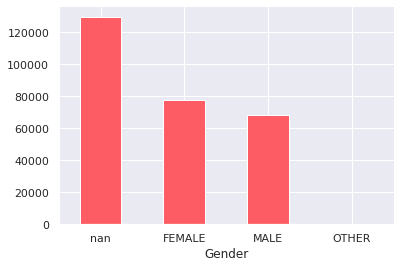

In [268]:
users.gender.value_counts(dropna=False).plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Gender')
sns.despine()

-  여행 시 성별에 따른 선호도가 있는지 확인할 수 있나?

</br>

NaN데이터 빼고 남녀의 선호도 차이 확인하기 


In [269]:
women = sum(users['gender'] == 'FEMALE')
men = sum(users['gender'] == 'MALE')

female_destinations = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

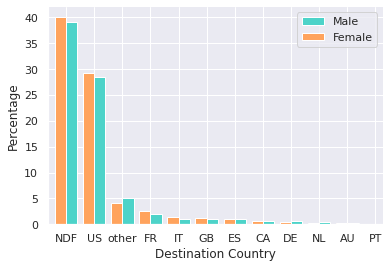

In [270]:
male_destinations.plot(kind='bar', width=0.4, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=0.4, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

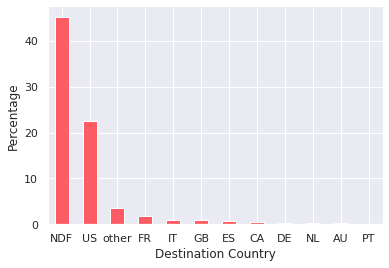

In [271]:
destination_percentage = users.country_destination.value_counts() / users.shape[0] * 100
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)

# Using seaborn can also be plotted
# sns.countplot(x="country_destination", data=users, order=list(users.country_destination.value_counts().keys()))
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

### Age

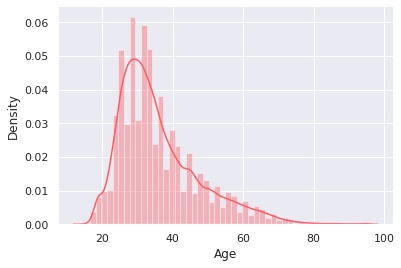

In [272]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

### Lang

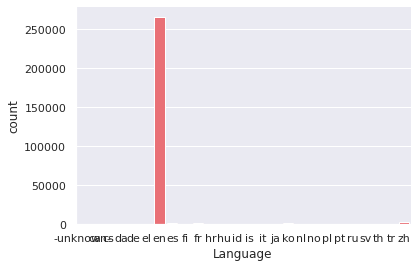

In [273]:
sns.countplot(data=users, x= "language", color='#FD5C64')
plt.xlabel('Language')
sns.despine()

In [274]:
users[users.language != "en"]["language"].value_counts()

zh           2634
fr           1508
es           1174
ko           1116
de            977
it            633
ru            508
ja            345
pt            322
sv            176
nl            134
tr             92
da             75
pl             75
no             51
cs             49
el             30
th             28
hu             25
id             23
fi             20
ca              6
is              5
hr              2
-unknown-       1
en              0
Name: language, dtype: int64

오,, 너무 극단적이야 ,,,, 
```
96%의 사용자들이 영어를 그들의 언어로 사용하고 있기 때문에, 
많은 사람들이 미국에 머무는 것은 이해할 수 있습니다. 
만약 언어가 중요하다면, 왜 GB로 여행을 가지 않을까 
생각하는 사람이 있을 것입니다? 
우리는 또한 우리가 계산하지 않는 많은 요소들이 있다는 것을 
기억할 필요가 있습니다. 따라서 그러한 가정이나 예측을 하는 것은 
위험할 수 있습니다.
```

### Date 
- 사용자의 날짜와 사용자의 시간 범위, 시간별로 생성된 계정 수를 플롯

<Axes: >

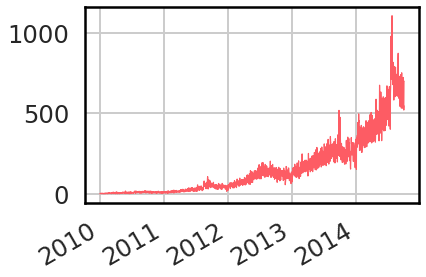

In [275]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
users.date_account_created.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

- 에어비앤비가 지난 3년간 성장하였음. 
- 사용자가 처음 가입한 날짜와 관련이 있을지? 

In [276]:
users

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,2009-03-19 04:32:55,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,2009-05-23 17:48:09,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,2009-12-08 06:11:05,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275542,2014-09-30,2014-09-30 23:52:32,NaN,31.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NaN
275543,2014-09-30,2014-09-30 23:53:06,NaN,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-,NaN
275544,2014-09-30,2014-09-30 23:54:08,NaN,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox,NaN
275545,2014-09-30,2014-09-30 23:54:30,NaN,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NaN


<Axes: >

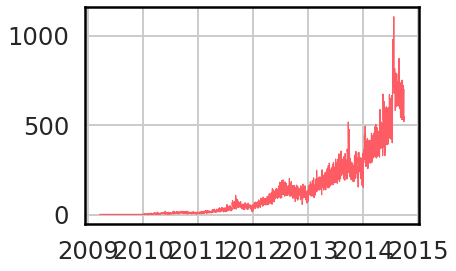

In [277]:
users['date_first_active'] = pd.to_datetime(users.timestamp_first_active, format='%Y%m%d%H%M%S')
users['date_first_active'] = users['date_first_active'].dt.date
users["date_first_active"].value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

- 2013 ~ 2014 , 2014 ~ 2015 사이 쯤 피크지점이 확인된다.

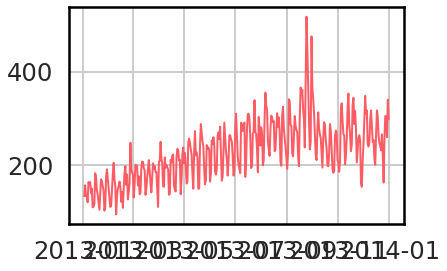

In [278]:
users_2013 = users[users['date_first_active'] > pd.to_datetime(20130101, format='%Y%m%d')]
users_2013 = users_2013[users_2013['date_first_active'] < pd.to_datetime(20140101, format='%Y%m%d')]
users_2013.date_first_active.value_counts().plot(kind='line', linewidth=2, color='#FD5C64')
plt.show()

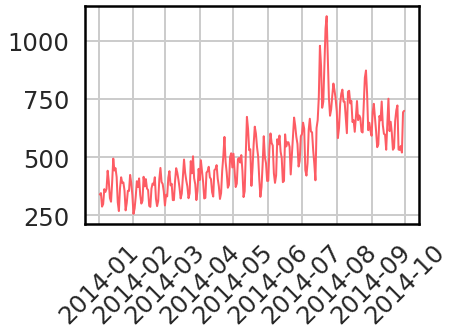

In [279]:
users_2014 = users[users['date_first_active'] > pd.to_datetime(20140101, format='%Y%m%d')]
users_2014 = users_2014[users_2014['date_first_active'] < pd.to_datetime(20150101, format='%Y%m%d')]
users_2014.date_first_active.value_counts().plot(kind='line', linewidth=2, color='#FD5C64',rot=45)
plt.show()

In [280]:
users[['date_first_active']]

,date_first_active
0,2009-03-19
1,2009-05-23
2,2009-06-09
3,2009-10-31
4,2009-12-08
...,...
275542,2014-09-30
275543,2014-09-30
275544,2014-09-30
275545,2014-09-30


### dayofweek

In [281]:
weekdays = []
for date in users.date_account_created:
    weekdays.append(date.weekday())
weekdays = pd.Series(weekdays)

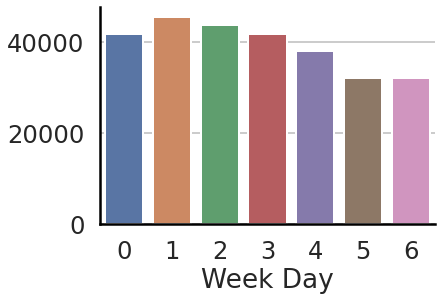

In [282]:
sns.barplot(x = weekdays.value_counts().index, y=weekdays.value_counts().values, order=range(0,7))
plt.xlabel('Week Day')
sns.despine()

- 화요일이 피크

### Min / Max Date in our data

In [283]:
print(users.date_account_created.min())
print(users.date_account_created.max())

2010-01-01 00:00:00
2014-09-30 00:00:00


### Signup method used by users

In [284]:
users['signup_method'].value_counts()

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64

<Axes: >

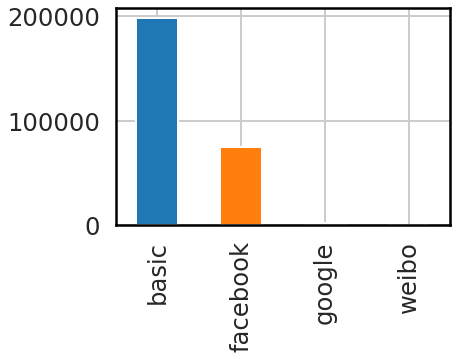

In [285]:
users["signup_method"].value_counts(dropna=False).plot(kind='bar', color=colors)

### User Devices

In [286]:
users['first_device_type'].value_counts()

Mac Desktop           106328
Windows Desktop        86948
iPhone                 39814
iPad                   18036
Other/Unknown          11167
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
SmartPhone (Other)       191
Name: first_device_type, dtype: int64

<Axes: >

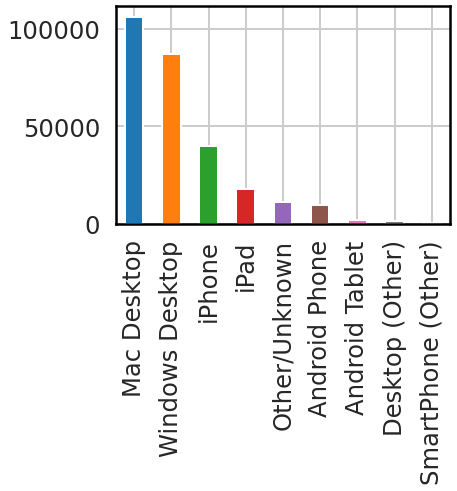

In [287]:
users["first_device_type"].value_counts(dropna=False).plot(kind='bar', color=colors)

### detailed view with % percent

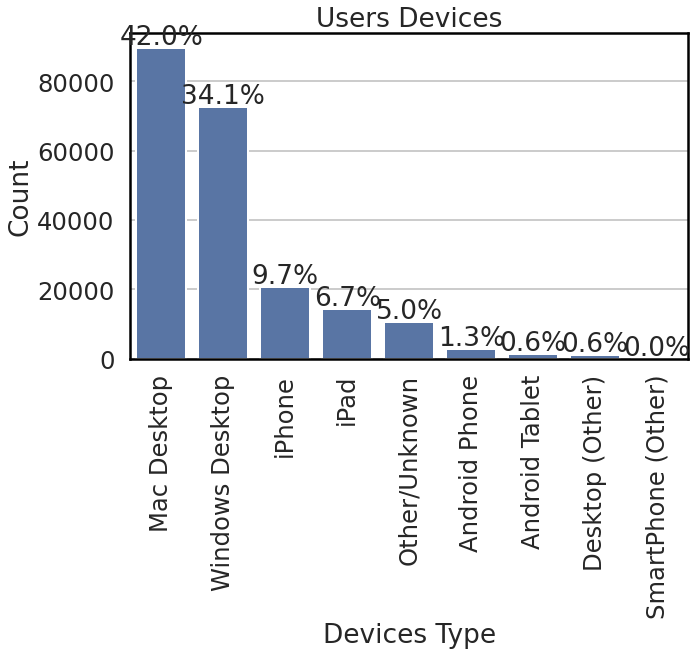

In [288]:
plt.figure(figsize=(10,6))
cd_count_idx = bookings_data['first_device_type'].value_counts().index
sns.countplot(data = bookings_data, x = 'first_device_type', order = cd_count_idx, color = sns.color_palette()[0])

plt.xlabel('Devices Type')
plt.ylabel('Count')
plt.title('Users Devices')
plt.xticks(rotation=90)


cd_count_val = bookings_data['first_device_type'].value_counts()

# 퍼센테이지 값 표시 
for i in range(cd_count_val.shape[0]):
    count = cd_count_val[i]
    percentage ='{:0.1f}%'.format(100 * count / len(bookings_data))
    plt.text(i, count+1000, percentage, ha='center')

### Internet browsers used

In [289]:
users['first_browser'].value_counts()[:20]

Chrome                78671
Safari                53302
-unknown-             44394
Firefox               38665
Mobile Safari         29636
IE                    24744
Chrome Mobile          3186
Android Browser        1577
AOL Explorer            254
Opera                   228
Silk                    172
IE Mobile               118
BlackBerry Browser       89
Chromium                 83
Mobile Firefox           64
Maxthon                  60
Apple Mail               45
Sogou Explorer           43
SiteKiosk                27
Iron                     24
Name: first_browser, dtype: int64

### Top 10 browsers


<Axes: >

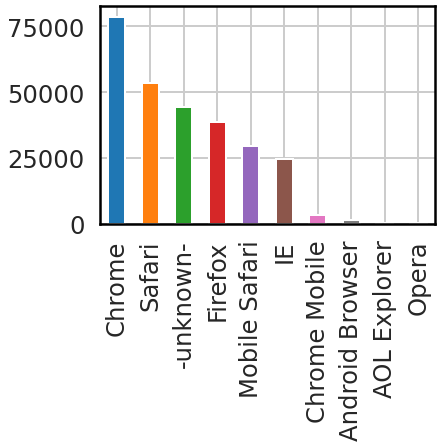

In [290]:
users['first_browser'].value_counts().head(10).plot(kind='bar', color=colors)

### Gender and Age -year
- 평균 연령은 35세 전후
- 남성보다 여성 사용자가 더 많다. 

In [291]:
users['gender'].value_counts()

FEMALE    77524
MALE      68209
OTHER       334
Name: gender, dtype: int64

In [292]:
users.groupby('gender').age.agg(['min','max','mean','count'])

,min,max,mean,count
gender,,,,
FEMALE,15.0,95.0,35.676545,70761
MALE,15.0,95.0,36.232610,63398
OTHER,17.0,78.0,35.876812,276


In [293]:
# 나이에 따라 연령대 파생변수 생성
users['member_age_bins']= users['age'].apply(lambda x: '18 - 20' if 18<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else '60-70' if 60<x<=70
                                                  else '70+' if 70<x<=100
                                                  else np.nan)

In [294]:
users[['age', 'member_age_bins']].head()

,age,member_age_bins
0,NaN,NaN
1,38.0,30 - 40
2,56.0,50 - 60
3,42.0,40 - 50
4,41.0,40 - 50


In [296]:
# 2013년 데이터만 추출
df_2013= users[users['date_account_created'].dt.year==2013]
df_2013['monthYear13'] = df_2013['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df_2013= df_2013.groupby(['monthYear13','member_age_bins']).count()

df_2013.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

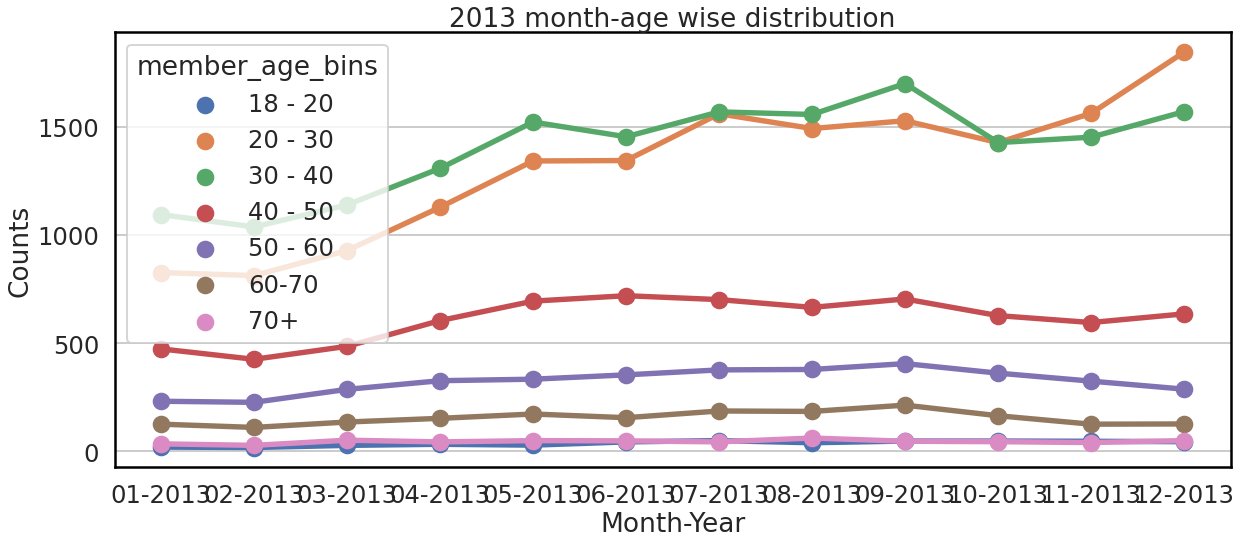

In [298]:
# 2013년 연령대 추이
plt.figure(figsize=[20,8])
sns.pointplot(data=df_2013, x='monthYear13', y='affiliate_provider', hue='member_age_bins');
plt.title('2013 month-age wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

In [299]:
df_gender = users[users['date_account_created'].dt.year==2013]
df_gender['monthYear13'] = df_gender['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df_gender= df_gender.groupby(['monthYear13','gender']).count()

df_gender.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

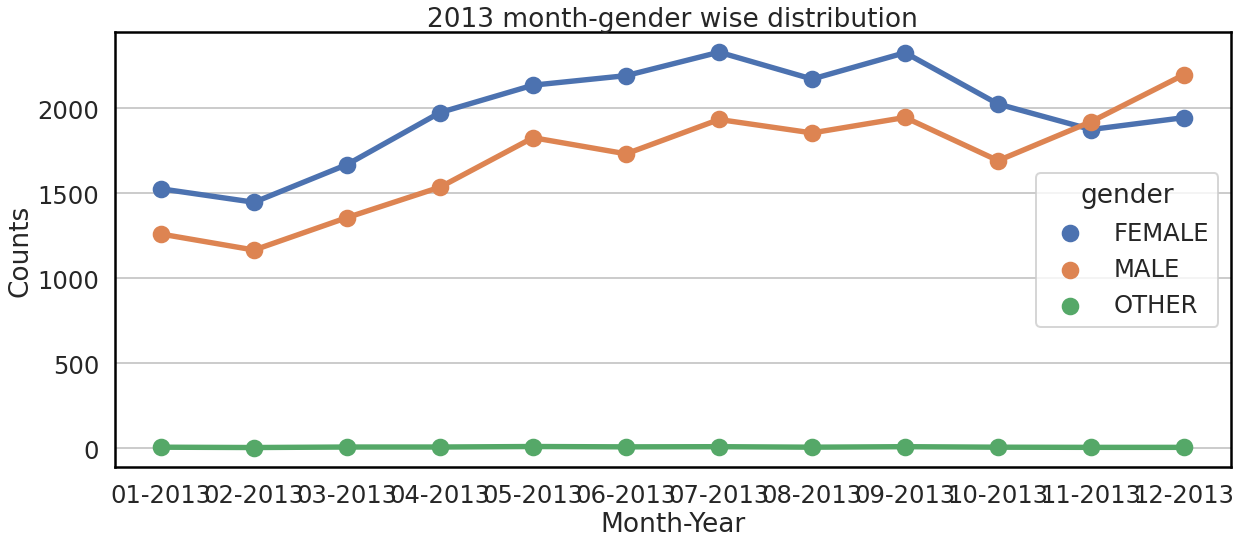

In [300]:
# 2013년 데이터 성별 추이

plt.figure(figsize=[20,8])
sns.pointplot(data=df_gender, x='monthYear13', y='affiliate_provider', hue='gender');

plt.title('2013 month-gender wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

In [301]:
# 2014년 데이터만 추출
df_2014= users[users['date_account_created'].dt.year==2014]
df_2014['monthYear14'] = df_2014['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df_2014= df_2014.groupby(['monthYear14','member_age_bins']).count()

df_2014.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

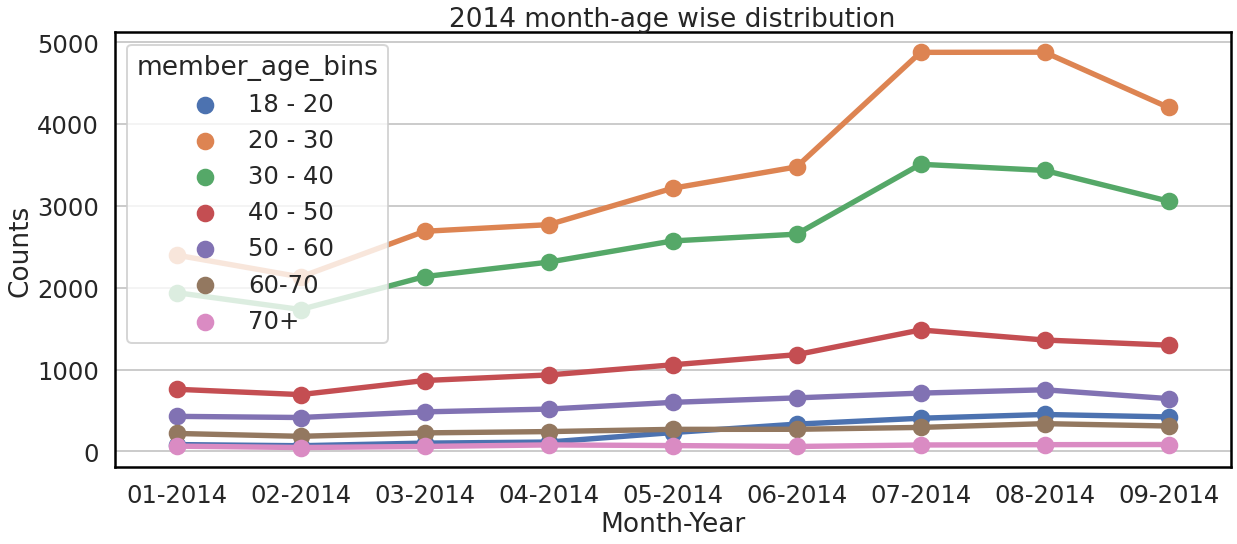

In [302]:
# 2014년 연령대 추이

plt.figure(figsize=[20,8])
sns.pointplot(data=df_2014, x='monthYear14', y='affiliate_provider', hue='member_age_bins');
plt.title('2014 month-age wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

In [308]:
# 2014년 데이터만 추출
df_gender_14 = users[users['date_account_created'].dt.year==2014]
df_gender_14['monthYear14'] = df_gender_14['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df_gender_14= df_gender_14.groupby(['monthYear14','gender']).count()

df_gender_14.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

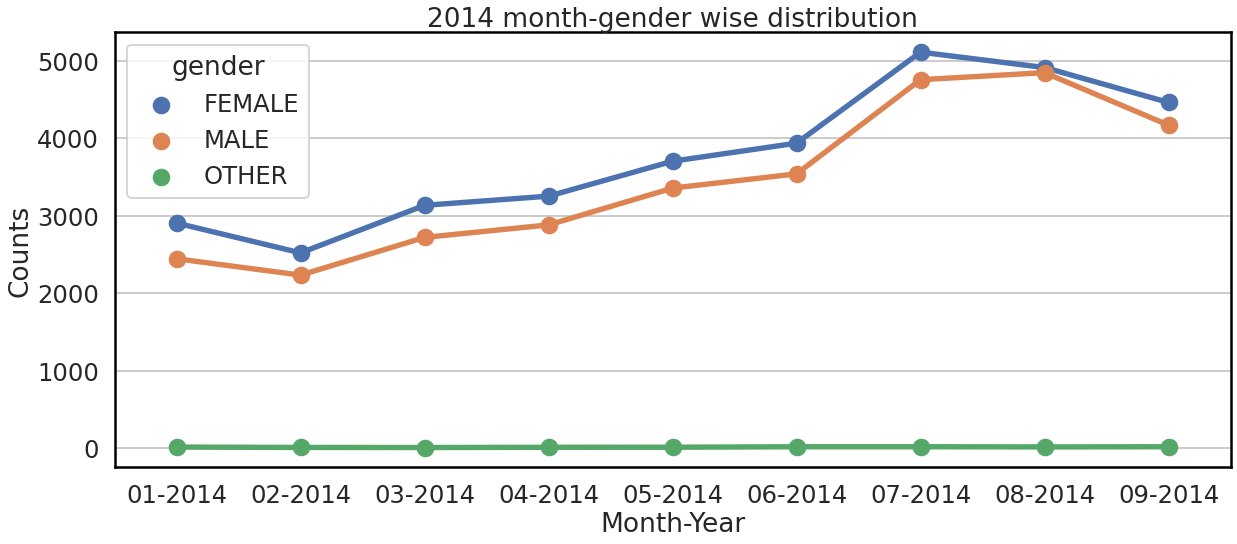

In [309]:
# 2014년 데이터 성별 추이

plt.figure(figsize=[20,8])
sns.pointplot(data=df_gender_14, x='monthYear14', y='affiliate_provider', hue='gender');

plt.title('2014 month-gender wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

## Data Preprocessing 

#### 자현님 코드 참조 

In [311]:
train_df = train_df.drop(['country_destination'], axis=1)

In [313]:
print(train_df.shape)
train_df.head(2)

(213451, 15)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome


In [314]:
print(test_df.shape)
test_df.head(2)

(62096, 15)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01 00:00:06,NaT,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,2014-07-01 00:00:51,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari


In [315]:
users = pd.concat((train_df, test_df), axis=0, ignore_index=True)

# data_first_booking은 결측치가 너무 많아 제거
df_all  = users.drop(['id', 'date_first_booking'], axis=1)

# 나머지 결측치는 -1로 채우기
df_all = df_all.fillna(-1)